In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
from GP_funcs import *
import corner
import scipy
import pickle 

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [7]:
with open("residual_sim_dict.pkl", "rb") as f:
    residual_sim_dict = pickle.load(f)

In [48]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_main = sim_interpolator(sim_main, 1)
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]
sims = []

for lev, rad in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=rad)
        sims.append(sim)
    except:
        pass

In [95]:
l_max = 4
n_max = 3

t0 = 0
T = 50

analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0+T - 1e-9)
analysis_times = sim_main.times[analysis_mask]

#qnm_list = [(ell,2,n,1) for ell in np.arange(2, l_max+1) for n in np.arange(0, n_max+1)]
#spherical_modes = [(ell, 2) for ell in np.arange(2, l_max+1)]

qnm_list = [(ell,m,n,p) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1) for n in np.arange(0, n_max+1) for p in [-1,1]]
spherical_modes = [(ell, m) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [96]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] 

ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

ls_c = ls_fit['C']

true_as = []
for re_c, im_c in zip(np.real(ls_fit['C']), np.imag(ls_fit['C'])):
    true_as.append(re_c)
    true_as.append(im_c)

true_params = true_as

In [97]:
residual_amplitudes = {}

for ell, m in residual_sim_dict[id].keys():
    residual_amplitudes[(ell, m)] = np.max(np.abs(residual_sim_dict[id][ell, m][analysis_mask]))

In [114]:
# Kernel parameters

qnm_decay_time = {}
qnm_lambda = {}

hyperparam_dict_base = {}
for ell, m in spherical_modes:
    omega = qnmfits.qnm.omega(ell, m, 0, 1, sim_main.chif_mag, sim_main.Mf)
    sigma_scale = 1
    ts_scale = 1
    tau_scale = 1
    lam_scale = 1
    hyperparam_dict_base[ell,m] = {
        'sigma_max': residual_amplitudes[ell,m] * sigma_scale,
        'sigma_min': residual_amplitudes[ell,m] / 10,
        't_s': 17 * ts_scale,
        'sharpness': 16,
        'length_scale': -1/omega.imag * tau_scale,
        'period': (2*np.pi)/omega.real * lam_scale
    }

hyperparam_dict_tuned = {}
for ell, m in spherical_modes:
    omega = qnmfits.qnm.omega(ell, m, 0, 1, sim_main.chif_mag, sim_main.Mf)
    sigma_scale = 1.3210526315691908
    ts_scale = 1.3003095975203829
    tau_scale = 1.0507527992111134
    lam_scale = 0.8631578947368252
    hyperparam_dict_tuned[ell,m] = {
        'sigma_max': residual_amplitudes[ell,m] * sigma_scale,
        'sigma_min': residual_amplitudes[ell,m] / 10,
        't_s': 17 * ts_scale,
        'sharpness': 16,
        'length_scale': -1/omega.imag * tau_scale,
        'period': (2*np.pi)/omega.real * lam_scale
    }

In [115]:
kernel_dict_base = {} 
n_times = len(analysis_times)

for (ell, m) in spherical_modes:
    kernel_dict_base[(ell, m)] = kernel(np.asarray(analysis_times), **hyperparam_dict_base[ell,m]) + np.eye(len(analysis_times)) * 1e-14

kernel_dict_tuned = {}

for (ell, m) in spherical_modes:
    kernel_dict_tuned[(ell, m)] = kernel(np.asarray(analysis_times), **hyperparam_dict_tuned[ell,m]) + np.eye(len(analysis_times)) * 1e-14

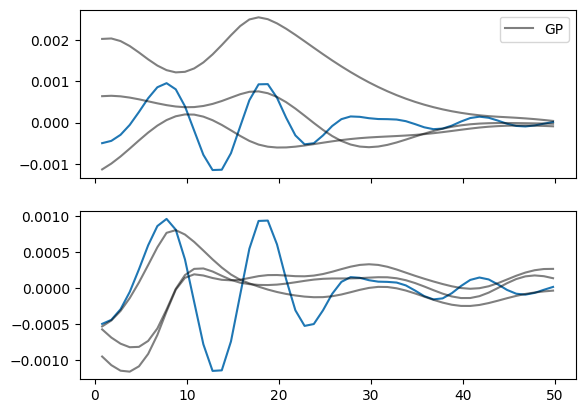

In [116]:
rng = np.random.default_rng()

fig, axs = plt.subplots(2, 1, sharex=True)

ell, m =  (3, 2)

axs[0].plot(sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell,m])[analysis_mask])
axs[1].plot(sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell,m])[analysis_mask])

repeats = 3

gp_samples_base = rng.multivariate_normal(np.zeros(n_times), kernel_dict_base[ell,m], size=repeats)
gp_samples_tuned = rng.multivariate_normal(np.zeros(n_times), kernel_dict_tuned[ell,m], size=repeats)

for j, draw in enumerate(gp_samples_base):
    label = 'GP' if j == 0 else None
    axs[0].plot(analysis_times, draw, color='black', alpha=0.5, label=label)

for j, draw in enumerate(gp_samples_tuned):
    label = 'GP' if j == 0 else None
    axs[1].plot(analysis_times, draw, color='black', alpha=0.5, label=label)

axs[0].legend()

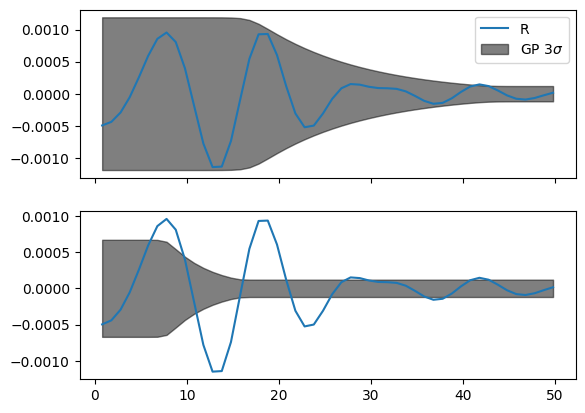

In [117]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell,m])[analysis_mask], label='R')
axs[1].plot(sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell,m])[analysis_mask], label='R')

# Plot the 1-sigma credible region of the GP
axs[0].fill_between(
    analysis_times, 
    -np.sqrt(np.diag(kernel_dict_base[ell,m])), 
    np.sqrt(np.diag(kernel_dict_base[ell,m])),
    color='black', 
    alpha=0.5,
    label='GP 3$\sigma$'
    )

axs[1].fill_between(
    analysis_times, 
    -np.sqrt(np.diag(kernel_dict_tuned[ell,m])), 
    np.sqrt(np.diag(kernel_dict_tuned[ell,m])),
    color='black', 
    alpha=0.5,
    label='GP 3$\sigma$'
    )

axs[0].legend()

In [118]:
kernel_dict_inv_base = {(ell,m): np.linalg.inv(kernel_dict_base[ell,m]) for ell,m in spherical_modes}
kernel_dict_inv_tuned = {(ell,m): np.linalg.inv(kernel_dict_tuned[ell,m]) for ell,m in spherical_modes}

# Convert kernel_dict_inv to a matrix
kernel_matrix_inv_base = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)
kernel_matrix_inv_tuned = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_base[idx, :, :] = kernel_dict_inv_base[(ell, m)]

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_tuned[idx, :, :] = kernel_dict_inv_tuned[(ell, m)]

In [119]:
fisher_matrix_base = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv_base, T=T)  
b_vec_base = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv_base, T=T)

fisher_matrix_tuned = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv_tuned, T=T)
b_vec_tuned = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv_tuned, T=T)

Precomputation time:  0.07358145713806152
Fisher matrix computation time:  7.209587574005127
Precomputation time:  0.03955841064453125
Fisher matrix computation time:  7.201570987701416


In [120]:
mean_vector_base = np.linalg.solve(fisher_matrix_base, b_vec_base)
mean_vector_tuned = np.linalg.solve(fisher_matrix_tuned, b_vec_tuned)

covariance_matrix_base = np.linalg.inv(fisher_matrix_base)
covariance_matrix_tuned = np.linalg.inv(fisher_matrix_tuned)

In [121]:
print(mean_vector_base)
print(mean_vector_tuned)
print(true_params)

[ 9.59345876e-01  1.99854192e-01  1.61293571e-02 -1.01505010e-02
 -2.23442778e+00  3.13487603e+00 -6.29916129e-01  1.04577198e-01
 -2.55880693e+00 -6.26258498e+00 -1.53396233e-01  2.60324036e+00
  3.94805635e+00  8.50383683e-01  1.71385032e+00 -6.69161357e-02
 -1.63066679e-08  1.16433036e-08  4.54797026e-11 -4.35577559e-10
  9.16543754e-08 -1.76004597e-08 -2.79328707e-10  1.68853443e-08
 -3.22709701e-07 -7.25217368e-08  5.22552603e-08 -1.29394014e-07
  3.97955307e-07  3.68921394e-08 -2.01631764e-07  1.20456981e-07
  1.03442030e-02 -1.42425498e-02  1.03442030e-02  1.42425497e-02
  2.00412715e-02  9.17825464e-02  2.00412699e-02 -9.17825465e-02
 -2.15574039e-01 -1.57007280e-01 -2.15574037e-01  1.57007284e-01
  2.04587256e-01 -5.97836403e-02  2.04587256e-01  5.97836380e-02
  2.63180069e-10  4.01879286e-10 -1.63932055e-08 -1.18331638e-08
 -6.07641579e-09 -1.49523045e-08  9.00394319e-08  2.00303765e-08
  7.76355776e-08  1.09443917e-07 -3.06201966e-07  6.95772024e-08
 -2.15582425e-07 -8.59256

In [122]:
covariance_matrix_reg_base = covariance_matrix_base + np.eye(covariance_matrix_base.shape[0]) * 1e-10
covariance_matrix_reg_tuned = covariance_matrix_tuned + np.eye(covariance_matrix_tuned.shape[0]) * 1e-10

In [123]:
samples = scipy.stats.multivariate_normal(mean_vector_base, covariance_matrix_reg_base, allow_singular=True).rvs(size=10000)
samples_ = scipy.stats.multivariate_normal(mean_vector_tuned, covariance_matrix_reg_tuned, allow_singular=True).rvs(size=10000)

In [124]:
def qnm_model(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    model = { mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes }
    for i, qnm in enumerate(qnm_list):  
        amp = amps[2*i] + 1j*amps[2*i+1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            model[ell, m] += amp * mu * np.exp(-1j*omega*(times-t0))
    return model

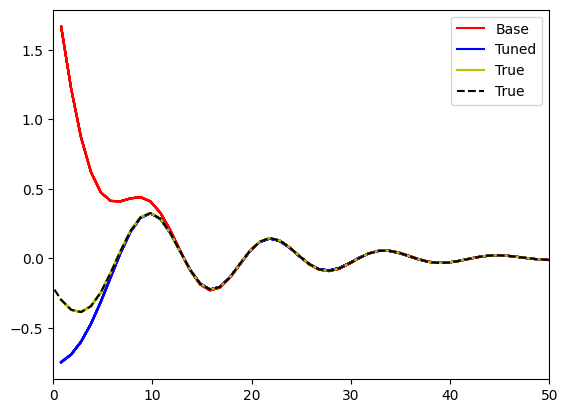

In [127]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = (2,2)
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ls = np.zeros((num_draws, len(analysis_times)), dtype=complex)

for i, idx in enumerate(indices):
    posterior_signals[i] = qnm_model(analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_[i] = qnm_model(analysis_times, t0, samples_[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_ls[i] = qnm_model(analysis_times, t0, true_params, qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]

    plt.plot(analysis_times, np.real(posterior_signals[i]), label='Base' if i==0 else None, color='r')
    plt.plot(analysis_times, np.real(posterior_signals_[i]), label='Tuned' if i==0 else None, color='b')
    plt.plot(analysis_times, np.real(posterior_signals_ls[i]), label='True' if i==0 else None, color='y')

plt.plot(sim_main.times, np.real(sim_main.h[ell,m]), label='True', color='black', ls='--')

plt.xlim(0, 50)
plt.legend()
plt.show()


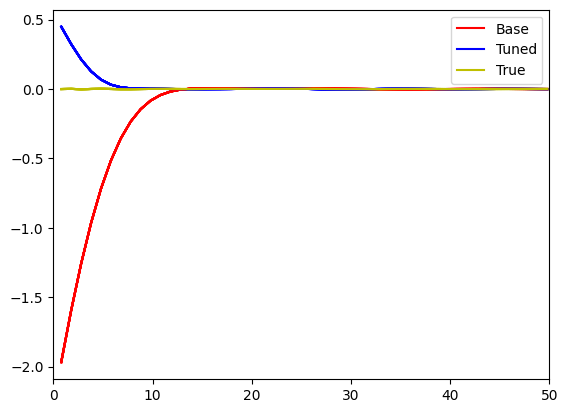

In [128]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = (2,2)
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)

data = np.interp(analysis_times, sim_main.times, np.real(sim_main.h[ell,m]))

for i, idx in enumerate(indices):
    posterior_signals[i] = qnm_model(analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_[i] = qnm_model(analysis_times, t0, samples_[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_ls[i] = qnm_model(analysis_times, t0, true_params, qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]

    plt.plot(analysis_times, data - np.real(posterior_signals[i]), label='Base' if i==0 else None, color='r')
    plt.plot(analysis_times, data- np.real(posterior_signals_[i]), label='Tuned' if i==0 else None, color='b')
    plt.plot(analysis_times, data - np.real(posterior_signals_ls[i]), label='True' if i==0 else None, color='y')

plt.xlim(0, 50)
plt.legend()
plt.show()